# TC Profiling Paper Plots

Manuel Peuster (manuel.peuster@uni-paderborn.de)

Plots that are used in paper (styling in optimized etc.).

## TODOs

- TODO do column plots with subplots (to save space, no y labels etc!)
- TODO show line style in legends
- TODO add legend background

In [309]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker
sns.set_style("ticks")
sns.set_context({"figure.figsize": (4.5, 3)})

## Load data

Do this only once since our data sources can be multiple GB! Uncompressed files are much faster.

In [310]:
#%time df = pd.read_pickle("data/2018-04-10-experiment_tc_paper_synthetic_all.combined.pkl")  # -r 30
%time df = pd.read_pickle("data/2019-09-26-experiment_tc_paper_synthetic_all.compressed.combined.pkl", compression="bz2")  # -r 100

CPU times: user 3.36 s, sys: 320 ms, total: 3.68 s
Wall time: 3.68 s


In [311]:
df.info()
print("Selectors:")
print(list(set(list(df["selector_conf"]))))
print("\n\nPredictors:")
print(list(set(list(df["predictor_conf"]))))
print("\n\nError Metrics:")
print(list(set(list(df["error"]))))
print("\n\nRepetitions:")
print(list(set(list(df["repetition_id"]))))
print("\n\nn_model_instances:")
print(list(set(list(df["n_model_instances"]))))
print("\n\topology:")
print(list(set(list(df["topology"]))))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604800 entries, 0 to 604799
Data columns (total 27 columns):
pmodel                      604800 non-null object
name                        604800 non-null object
n_model_instances           604800 non-null int64
topology                    604800 non-null object
selector                    604800 non-null object
selector_conf               604800 non-null object
k_samples                   604800 non-null int64
selector_time_next_sum      604800 non-null float64
selector_time_reinit_sum    604800 non-null float64
max_samples                 604800 non-null int64
predictor                   604800 non-null object
predictor_conf              604800 non-null object
degree                      604800 non-null int64
epsilon                     604800 non-null float64
max_tree_depth              604800 non-null int64
alpha                       604800 non-null float64
error                       604800 non-null object
sim_t_total            

## Filter data (globally)

In [312]:
#df = df[df["repetition_id"].isin([2, 3])]
#print("\nRepetitions:")
#print(list(set(list(df["repetition_id"]))))

#df = df[df["topology"] == "l3"]
#print("\nTopology:")
#print(list(set(list(df["topology"]))))

## Common Helpers

In [313]:
def _cartesian_product(p_dict):
    """
    Compute Cartesian product on parameter dict:
    In:
        {"number": [1,2,3], "color": ["orange","blue"] }
    Out:
        [ {"number": 1, "color": "orange"},
          {"number": 1, "color": "blue"},
          {"number": 2, "color": "orange"},
          {"number": 2, "color": "blue"},
          {"number": 3, "color": "orange"},
          {"number": 3, "color": "blue"}
        ]
    """
    p_names = sorted(p_dict)
    return [dict(zip(p_names, prod)) for prod in it.product(
        *(p_dict[n] for n in p_names))]

def _generate_filters(df, column_lst):
    """
    config defines arbitrary column names over which we want to iterate
    to create multiple plots, we fetch the possible values of each column
    from the dataset, and compute a float list (cartesian_product) of
    configuration combinations to be plotted
    """
    # extract possible values
    filter_dict = dict()
    for column in column_lst:
        filter_dict[column] = list(set(df[column]))
    # all combinations
    return _cartesian_product(filter_dict)

def _filter_df_by_dict(df, filter_dict):
    """
    do some Pandas magic to dynamically filter df by given dict
    filter_dict = {"column1": "value", "column2": ...}
    """
    return df.loc[
         (df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]

def _get_selector_name(sconf):
    if "WVS_bpm=0" in sconf:
        return "WVS0"
    if "WVS_bpm=1" in sconf:
        return "WVS1"
    if "WVS_bpm=2" in sconf:
        return "WVS2"
    if "WRVS_bpm=0" in sconf:
        return "WRVS0"
    if "WRVS_bpm=1" in sconf:
        return "WRVS1"
    if "WRVS_bpm=2" in sconf:
        return "WRVS2"
    if "PGAS_mbp=10" in sconf:
        return "PGAS10"
    if "PGAS_mbp=20" in sconf:
        return "PGAS20"
    return sconf.split("_")[0]

def _get_predictor_name(pconf):
    return pconf.split("_")[0]

def _get_error_name(err):
    if err == "MSE":
        return "mean squared error (MSE)"
    if err == "NRMSDR" or err == "NRMSDM":
        return "normalized RMSD"
    if err == "R":
        return "coefficient of determination ($R^2$)"
    return err

def _rewrite_legend_texts(leg, rewrite_func):
    for t in leg.texts:
        t.set_text(rewrite_func(t.get_text()))
    

In [314]:
def error_plot(df, filter_dict,
                  title="selector comparison",
                  x="k_samples", y="error_value",
                  hue="selector_conf", # errors are based on this grouping
                  error_bars=95, # ="sd" or =95 (for ci)
                  y_limit=None,
                  x_label="k samples",
                  y_label="error",
                  y_ticks_disabled = False,  # for multi column plots
                  fig_width=6,
                  fig_height=5,
                  legend_loc="lower right",#"lower center",#"best",
                  legend_ncol=1,
                  legend_rewrite_func=_get_predictor_name,
                  path=None):
    sns.set_style("ticks", rc={"legend.frameon": False})
    sns.set_context("paper",
                    font_scale=2.0,
                    rc={
                    "lines.linewidth": .7
                    })
    # filters (one filter per plot)
    if isinstance(filter_dict, dict):
        filter_dict_list = [filter_dict]
    else:
        filter_dict_list = filter_dict
    # iterate over all filters to gen. diff. plots
    for f in filter_dict_list:
        # select data to be plotted
        dff = _filter_df_by_dict(df, f)
        if len(dff) < 1:
            print("Filter {} returned 0 data entires.".format(f))
            continue  # nothing to plot
        print("Filtered plot data has {} entries".format(len(dff)))
        fig, ax = plt.subplots(
            figsize=(fig_width,
                     fig_height),
                     dpi=300)
        
        #print(dff)
       
        # do plot
        sns.pointplot(ax=ax,
                      data=dff,
                      x=x,
                      y=y,
                      hue=hue,
                      ci=error_bars,  # ci="sd" or ci=95
                      capsize=.3,
                      markers=["o", "s", "^", "v", "D", "p", "d", "P", "X" "*"],
                      linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":"],
                      #palette="hls",
                      color="dimgray"  # "darkgray"=different grays
                     )

        # custom markers (seaborn does not support it well)
        plt.setp(ax.collections, sizes=[50], facecolor='none')  
        # create legend
        #leg = ax.legend(loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=(0., 1.02, 1., .102), borderaxespad=0.)
        leg = ax.legend(loc=legend_loc, ncol=legend_ncol, frameon=True, fancybox=False, framealpha=1, shadow=False, borderpad=.1, edgecolor="black") #mode="expand",
        _rewrite_legend_texts(leg, legend_rewrite_func)
        #fig.suptitle(title)
        ax.set_title(title)
        ax.set_ylabel(y_label)
        # remove y ticks
        if y_ticks_disabled:
            #ax.set_yticks([])
            ax.set_yticklabels([])
        ax.set_xlabel(x_label)
        if y_limit is not None:
            ax.set_ylim(y_limit)
        if path is not None:
            plt.savefig(path, bbox_inches="tight")
        plt.show()

## Selector Study

Filtered plot data has 4320 entries


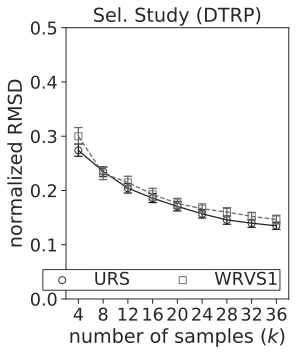

In [315]:
ERRORS = ['NRMSDR']#, 'NRMSDM', "MSE"]
SELECTORS = [#'WVS_bpm=2-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=4-smmm=2',
             'URS',
             #'WVS_bpm=0-bpmp=False-pspv=16-smmm=2',
             #'PGAS_mbp=20',
             #'WVS_bpm=1-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=4-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=8-smmm=2',
             ##'PGAS_mbp=10',
             #'WVS_bpm=2-bpmp=False-pspv=4-smmm=2',
             'WRVS_bpm=1-bpmp=False-pspv=-1-smmm=2',
             ##'WRVS_bpm=2-bpmp=False-pspv=-1-smmm=2',
             #'WRVS_bpm=0-bpmp=False-pspv=-1-smmm=2'
            ]
PREDICTORS = ['DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
              ##'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              ##'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2',
              ##'RRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2'
             ]

# remove unneeded selectors
dff = df[df["selector_conf"].isin(SELECTORS)]

for pred in PREDICTORS:
    for err in ERRORS:
        error_plot(
                dff, 
                {#"topology": topo,
                 "predictor_conf": pred,
                 "error": err
                },
                title="Sel. Study ({})".format(_get_predictor_name(pred)),
                x_label = "number of samples ($k$)",
                y_label = _get_error_name(err),
                y_limit=[0.0, .5] if err == "NRMSDR" else [0, 1],
                fig_width=4,
                fig_height=5,
                legend_ncol=2,
                legend_rewrite_func=_get_selector_name,
                path="plots/diss_selector_study_{}_{}.pdf".format(_get_predictor_name(pred), err),
            )

In [316]:
df.head()

,pmodel,name,n_model_instances,topology,selector,selector_conf,k_samples,selector_time_next_sum,selector_time_reinit_sum,max_samples,...,sim_t_total,sim_t_mean,error_value,conf_id,repetition_id,max_border_points,border_point_mode,sampling_mode_maxmin,p_samples_per_vnf,border_point_mode_panic
0,RSM.l2.0,SVRPredictorRbfKernel,1,l2,URS,URS,4,0.000202,0.000002,4,...,240,60.0,0.005242,1,14,NaN,NaN,NaN,NaN,NaN
1,RSM.l2.0,SVRPredictorRbfKernel,1,l2,URS,URS,4,0.000202,0.000002,4,...,240,60.0,0.072405,1,14,NaN,NaN,NaN,NaN,NaN
2,RSM.l2.0,SVRPredictorRbfKernel,1,l2,URS,URS,4,0.000202,0.000002,4,...,240,60.0,0.082538,1,14,NaN,NaN,NaN,NaN,NaN
3,RSM.l2.0,SVRPredictorRbfKernel,1,l2,URS,URS,4,0.000202,0.000002,4,...,240,60.0,0.326268,1,14,NaN,NaN,NaN,NaN,NaN
4,RSM.l2.0,DecisionTreeRegressionPredictor,1,l2,URS,URS,4,0.000133,0.000001,4,...,240,60.0,0.003478,2,0,NaN,NaN,NaN,NaN,NaN


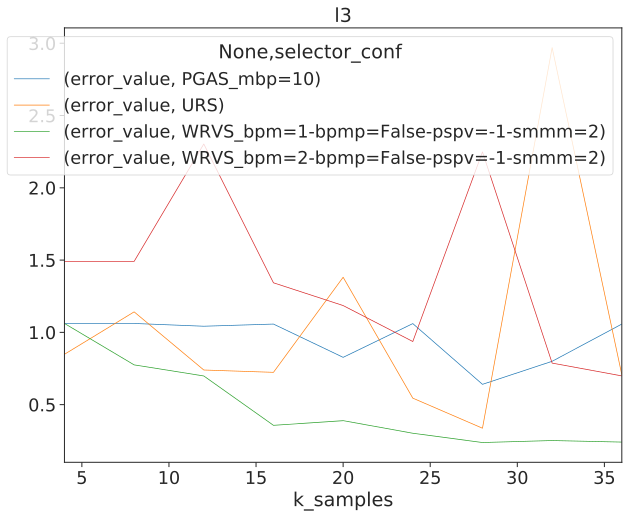

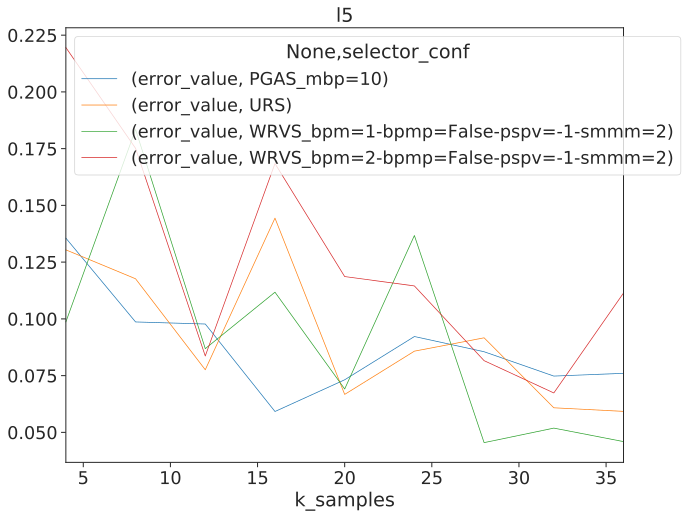

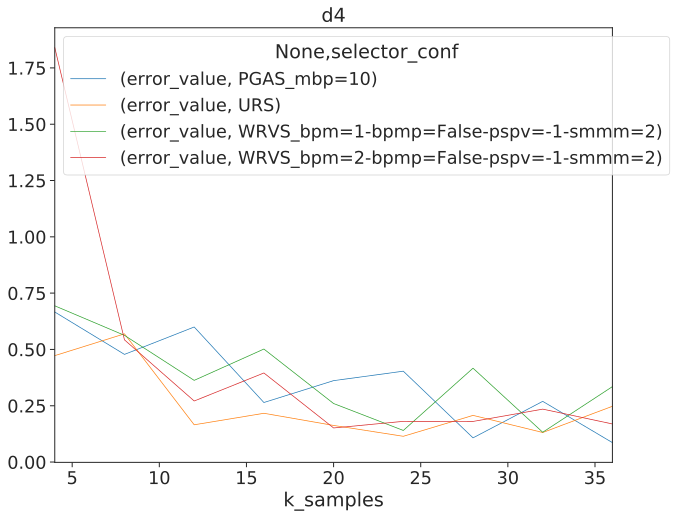

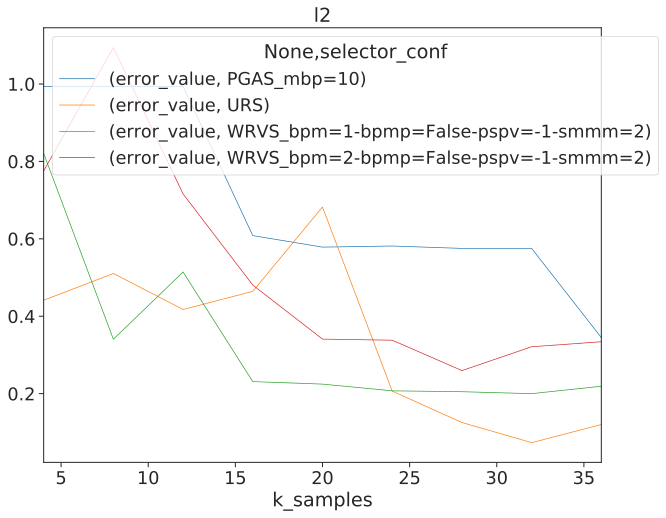

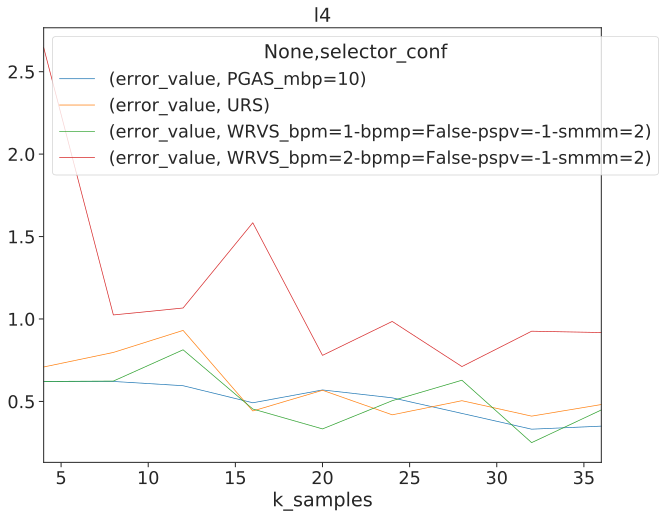

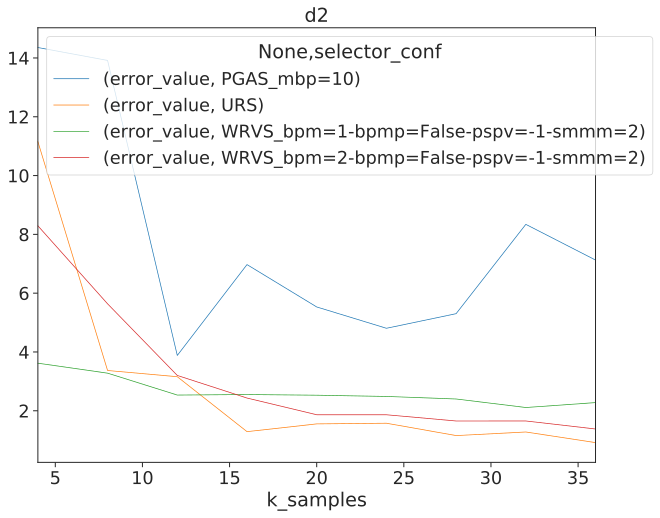

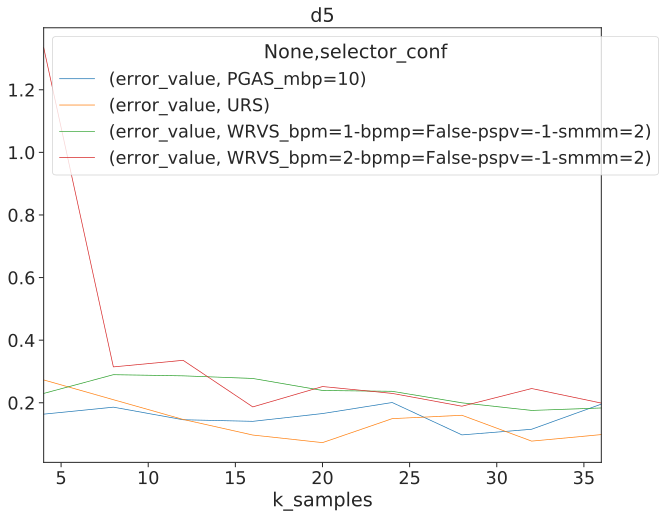

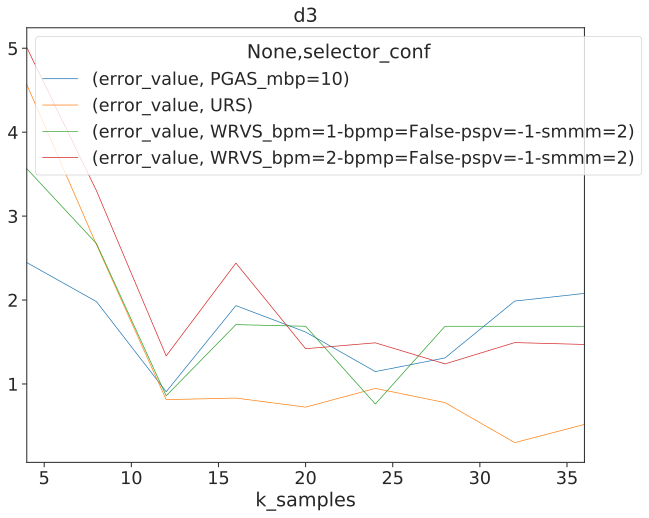

In [334]:
ERRORS = ['MSE']#, 'NRMSDR', NRMSDM', "MSE"]
SELECTORS = [#'WVS_bpm=2-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=4-smmm=2',
             'URS',
             #'WVS_bpm=0-bpmp=False-pspv=16-smmm=2',
             #'PGAS_mbp=20',
             #'WVS_bpm=1-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=4-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=8-smmm=2',
             'PGAS_mbp=10',
             #'WVS_bpm=2-bpmp=False-pspv=4-smmm=2',
             'WRVS_bpm=1-bpmp=False-pspv=-1-smmm=2',
             'WRVS_bpm=2-bpmp=False-pspv=-1-smmm=2',
             #'WRVS_bpm=0-bpmp=False-pspv=-1-smmm=2'
            ]
PREDICTORS = ['DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
              ##'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              ##'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2',
              ##'RRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2'
             ]
for t in list(set(list(df["topology"]))):
    # remove unneeded selectors
    dff = df[df["selector_conf"].isin(SELECTORS)]
    dff = dff[dff["predictor_conf"].isin(PREDICTORS)]
    dff = dff[dff["error"].isin(ERRORS)]
    dff = dff[dff["topology"] == t]
    dff = dff[["k_samples", "error_value", "selector_conf"]]

    #g = dff.groupby(["k_samples", "selector_conf"]).agg({'error_value':'mean'})
    #g.unstack(level=1).plot(subplots=False, figsize=(10,8))

    g = dff.groupby(["k_samples", "selector_conf"]).agg({'error_value':'max'})
    g.unstack(level=1).plot(subplots=False, figsize=(10,8), title=t)